In [30]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('../')

# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.umbrella_length_dataset import UmbrellaLengthDataset
from envs.umbrella_length import get_umbrella_length_env
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [31]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, df, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=df['train/loss'].sum(),
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_reward'] for res in self.eval_results[n//2:]])
			
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

[[1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.]]


collecting trajectories:   0%|          | 0/2000 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 4
reward_scale: 1
return min=-4.0, max=4.0 mean=0.0155
state_mean: [[0.493    0.505125 0.625    0.49475  0.495875 0.511125 0.49925  0.512875
  0.494    0.496875 0.500625 0.502    0.500125 0.508375 0.498375 0.502625
  0.50375  0.50975  0.498125 0.5075   0.50425  0.5045   0.506625]]
state_std: [[0.49995187 0.499955   0.2795085  0.49995247 0.49997774 0.49987674
  0.49999896 0.49984747 0.4999465  0.49998358 0.49999928 0.4999942
  0.49999997 0.49992386 0.49999517 0.50001645 0.49998316 0.49991837
  0.4999947  0.49994758 0.49997616 0.49997142 0.49996135]]
gamma: 1


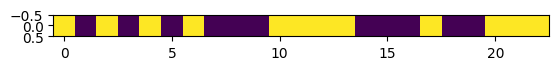

In [82]:
env = get_umbrella_length_env(chain_length=4)
obs, info = env.reset()
print(obs)
plt.imshow(obs)

# todo is this number of trajectories enough?
# todo should the reward scale be 1?
# todo make sure max_steps is not too much. we don't want the context length to be too big
traj_dataset = UmbrellaLengthDataset(env, n_trajectories=2000, reward_scale=1)

(array([134.,   0., 486.,   0.,   0., 730.,   0., 542.,   0., 108.]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <BarContainer object of 10 artists>)

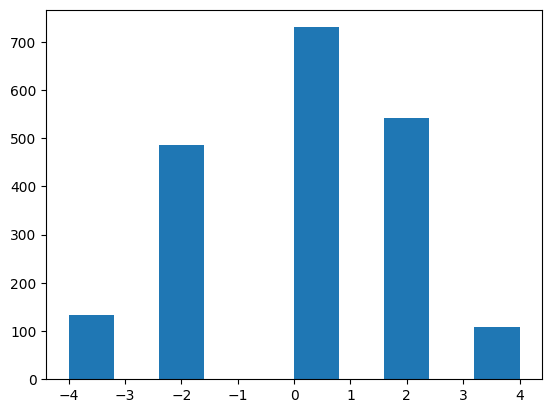

In [83]:
ds_rewards = np.array([traj_dataset.reward_convertor.from_feature_space(traj.returns[0]) for traj in traj_dataset])
# ds_pos_rewards = np.array([ret for ret in ds_rewards if ret > 0])
plt.hist(ds_rewards)

In [85]:
# todo rtg_range_check and rtg_main are used for plotting and monitoring
# todo is the rtg_range_check correct?
config = TrainConfig(max_eval_ep_len=20, context_len=3, rtg_range_check=(-4, 4), rtg_main=5, max_train_iters=100)

experiment_name = 'umbrella-length-experiment'

model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

trainer = TrainerDT(name=experiment_name, model=model,
					optimizer=optimizer, loss_fn=loss_fn,
					dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
					device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=[-4, 4])

trainer.register_callback(callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

number of parameters 1126426


In [86]:
report = trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

achieved average reward:  -0.8
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_umbrella-length-experiment_model_24-05-09-23-55-17_best.pt
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_umbrella-length-experiment_model_24-05-09-23-55-17.pt
time elapsed: 0:00:02
num of updates: 100
loss: 57.24299
eval avg reward: -0.80000
best score: -inf
eval_avg_ep_len 4.00000
grad_norm 0.16687
lr 0.00001
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_umbrella-length-experiment_model_24-05-09-23-55-17.pt
time elapsed: 0:00:04
num of updates: 200
loss: 27.54080
eval avg reward: -1.40000
best score: -0.80000
eval_avg_ep_len 4.00000
grad_norm 0.18126
lr 0.00002
achieved average reward:  1.0
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_umbrella-length-experiment_model_24-05-09-23-55-17_best.pt
saving current mode

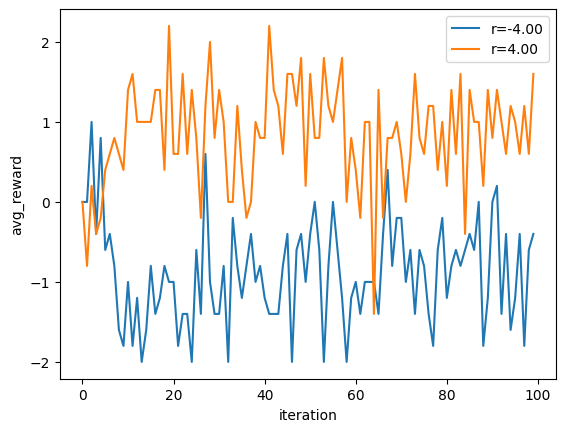

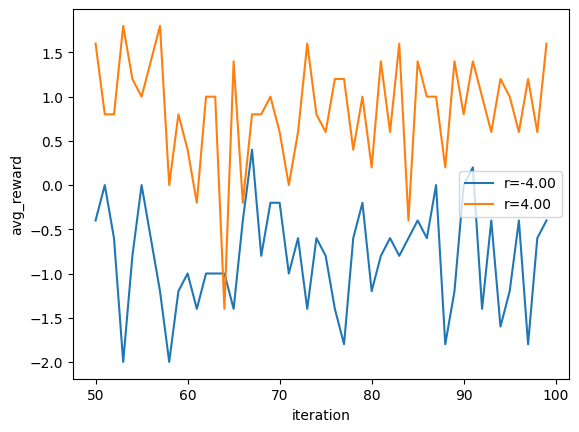

In [87]:
callback.plot_eval_results()

<Axes: >

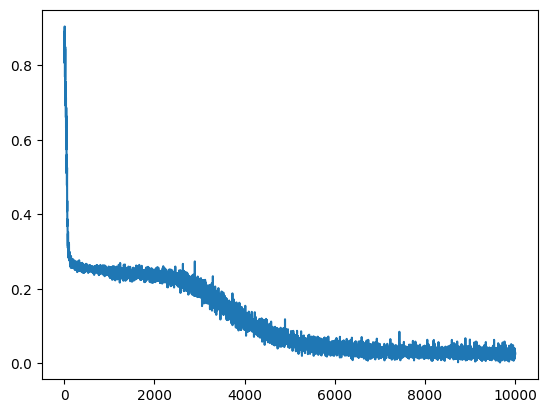

In [88]:
report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()

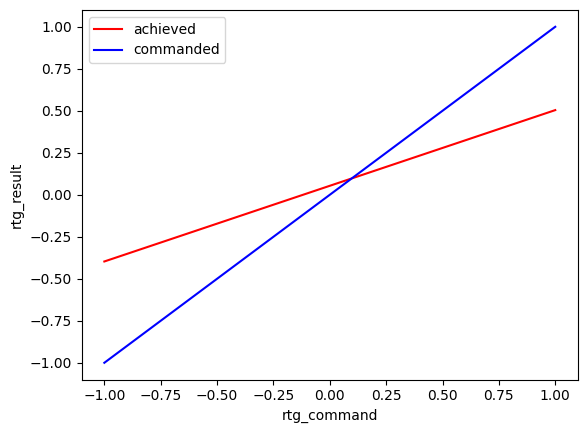

In [92]:
# rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)
rtg_command = [-1, 1]

rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=2000
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


plt.legend(["achieved", "commanded", "best"])